# Izaz Khan  
**Reg. No:** B23F0001AI029  
**Section:** AI Green  
**Course:** ML Lab 12

**Date:** 07/12/2025

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
# Load the dataset
df = pd.read_csv("/content/wines_SPA.csv")

In [ ]:
# 1. Create the Target Variable (Classification)
# Use pd.cut to create two classes by dividing the rating range into two equal bins
df['quality_label'] = pd.cut(df['rating'], bins=2, labels=[0, 1], include_lowest=True)
TARGET_COL = 'quality_label'

In [ ]:
# Drop columns not needed for modeling
df = df.drop(columns=['winery', 'wine', 'country', 'num_reviews', 'rating'])

In [ ]:
# --- Missing Value Imputation ---
# Numerical columns to impute with median
numerical_cols_to_impute = ['body', 'acidity']
for col in numerical_cols_to_impute:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
# Categorical column 'type': impute missing as 'Missing' category
df['type'] = df['type'].fillna('Missing')

In [ ]:
# --- Outlier Handling (on 'price') ---
# Use IQR method to cap extreme prices
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Cap outliers: prices below lower_bound are set to lower_bound, above upper_bound to upper_bound
df['price'] = np.where(df['price'] > upper_bound, upper_bound,
                       np.where(df['price'] < lower_bound, lower_bound, df['price']))

In [ ]:
print(f"Shape after cleaning: {df.shape}")
print(df.isnull().sum()) # Verify no more missing values

Shape after cleaning: (7500, 7)
year             2
region           0
price            0
type             0
body             0
acidity          0
quality_label    0
dtype: int64


##Feature Engineering
Justification
The year column is currently a string/object type, which is not directly usable by most ML algorithms. Furthermore, the actual vintage year is less important than the age of the wine. A feature representing the age of the wine (Current Year - Vintage Year) can capture the effect of aging on wine quality. We will use the current year (2025) and filter out non-standard years ('N.V.').

In [ ]:
# Assuming the current year is 2025 (as of the context date)
CURRENT_YEAR = 2025

In [ ]:
# Filter out 'N.V.' (Non-Vintage) rows and NaNs for simplicity in age calculation
df_filtered = df[df['year'].fillna('').str.isnumeric()].copy()

In [ ]:
# Convert year to numeric and calculate age
df_filtered['vintage_year'] = pd.to_numeric(df_filtered['year'], errors='coerce')
df_filtered['wine_age'] = CURRENT_YEAR - df_filtered['vintage_year']

# Drop the original 'year' and the intermediate 'vintage_year' column
df_filtered = df_filtered.drop(columns=['year', 'vintage_year'])

print(df_filtered[['wine_age', 'price', 'quality_label']].head())

   wine_age    price quality_label
0        12  100.025             1
1         7  100.025             1
2        16  100.025             1
3        26  100.025             1
4        29  100.025             1


##Encoding
Justification
The categorical features (region, type) need to be converted into a numerical format for the model. One-Hot Encoding is used here. It creates new binary (dummy) features for each unique category, ensuring the model does not assume any ordinal relationship between categories.

In [ ]:
# Identify categorical and numerical features after cleaning/engineering
CATEGORICAL_COLS = ['region', 'type']
NUMERICAL_COLS = ['price', 'body', 'acidity', 'wine_age']

# One-Hot Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_filtered[CATEGORICAL_COLS])
encoded_df = pd.DataFrame(encoded_features,
                          columns=encoder.get_feature_names_out(CATEGORICAL_COLS),
                          index=df_filtered.index)

In [ ]:
# Drop original categorical columns and concatenate the encoded ones
df_processed = df_filtered.drop(columns=CATEGORICAL_COLS)
df_processed = pd.concat([df_processed, encoded_df], axis=1)

print(f"Shape after encoding: {df_processed.shape}")
print(df_processed.columns.tolist())

Shape after encoding: (7210, 99)
['price', 'body', 'acidity', 'quality_label', 'wine_age', 'region_Abona', 'region_Alella', 'region_Alicante', 'region_Almansa', 'region_Andalucia', 'region_Aragon', 'region_Arinzano', 'region_Arribes', 'region_Bierzo', 'region_Binissalem-Mallorca', 'region_Cadiz', 'region_Calatayud', 'region_Campo de Borja', 'region_Carinena', 'region_Castilla', 'region_Castilla y Leon', 'region_Cataluna', 'region_Cava', 'region_Cigales', 'region_Conca de Barbera', 'region_Condado de Huelva', 'region_Costers del Segre', 'region_Dehesa del Carrizal', 'region_Dominio de Valdepusa', 'region_El Terrerazo', 'region_Emporda', 'region_Extremadura', 'region_Galicia', 'region_Gran Canaria', 'region_Jerez Palo Cortado', 'region_Jerez Pedro Ximenes (PX)', 'region_Jerez-Xeres-Sherry', 'region_Jumilla', 'region_La Mancha', 'region_La Palma', 'region_Madrid', 'region_Malaga', 'region_Mallorca', 'region_Mentrida', 'region_Monterrei', 'region_Montilla-Moriles', 'region_Montsant', 'regi

##Scaling
JustificationMinMaxScaler will be applied to the numerical features (price, body, acidity, wine_age). Scaling ensures all features contribute equally to the distance calculations or gradient descent optimization by transforming them into a range of [0, 1]. This is crucial for models sensitive to the scale of features, like $k$-Nearest Neighbors or models trained with gradient descent (e.g., Logistic Regression).

In [ ]:
# Separate features (X) and target (y)
X = df_processed.drop(columns=[TARGET_COL])
y = df_processed[TARGET_COL]

# Apply MinMaxScaler to the identified numerical columns
scaler = MinMaxScaler()
X[NUMERICAL_COLS] = scaler.fit_transform(X[NUMERICAL_COLS])

print(X[NUMERICAL_COLS].head())

   price      body  acidity  wine_age
0    1.0  1.000000      1.0  0.072072
1    1.0  0.666667      0.5  0.027027
2    1.0  1.000000      1.0  0.108108
3    1.0  1.000000      1.0  0.198198
4    1.0  1.000000      1.0  0.225225


##Train-Test Split
Justification
A 70/30 split is chosen to allocate a substantial portion (70%) of the data for model training while reserving a separate, unseen 30% for final, unbiased evaluation. Using random_state ensures the split is reproducible.

In [ ]:
# Perform the 70/30 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples (70%)")
print(f"Test set size: {X_test.shape[0]} samples (30%)")
print(f"Original target distribution: \n{y.value_counts(normalize=True)}")
print(f"Train target distribution: \n{y_train.value_counts(normalize=True)}")

Training set size: 5047 samples (70%)
Test set size: 2163 samples (30%)
Original target distribution: 
quality_label
0    0.952705
1    0.047295
Name: proportion, dtype: float64
Train target distribution: 
quality_label
0    0.952645
1    0.047355
Name: proportion, dtype: float64


##Apply PCA (Optional but Recommended)
Justification
PCA (Principal Component Analysis) is used for dimensionality reduction and noise reduction. After one-hot encoding, the feature space is quite large (over 100 dimensions). PCA can transform these potentially highly correlated features into a smaller set of orthogonal (uncorrelated) principal components that capture most of the variance. This can speed up training and mitigate the curse of dimensionality.

Component Selection: We will select the number of components that explain 95% of the total variance, as a common heuristic to retain most of the information while significantly reducing dimension.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=None) # Start with all components
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

In [ ]:
# Apply PCA with the selected number of components
pca_95 = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca_95.fit_transform(X_train)
X_test_pca = pca_95.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Selected components (95% variance): {n_components_95}")
print(f"Variance explained by {n_components_95} components: {cumulative_variance[n_components_95 - 1]:.4f}")

Original features: 98
Selected components (95% variance): 17
Variance explained by 17 components: 0.9523


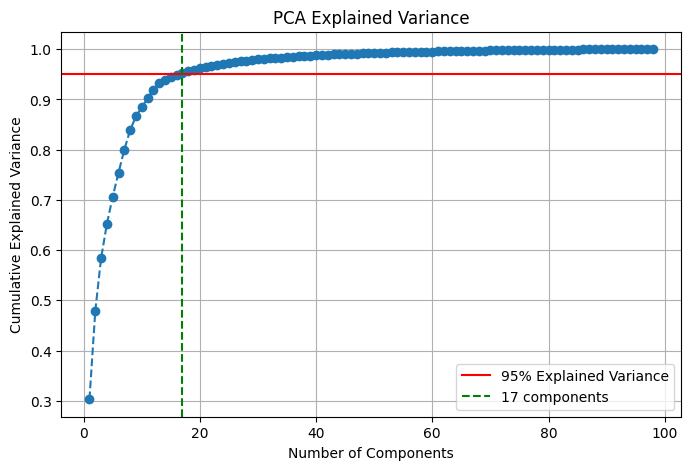

In [ ]:
# Explained Variance Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} components')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Use the PCA-transformed data for subsequent steps
X_train_final, X_test_final = X_train_pca, X_test_pca

##Apply At Least One ML Model (Logistic Regression)

Justification
I choose Logistic Regression for this binary classification task.

Simplicity and Interpretability: It is a linear model that is computationally efficient and provides easy-to-interpret feature coefficients. In a junior role, starting with a transparent model is often preferred.

Effective Baseline: It works well as a strong baseline model, especially after scaling and PCA, and its performance can be compared against more complex non-linear models later.

Built-in Regularization: It naturally supports L1, L2, and ElasticNet regularization directly through its parameters, fulfilling the next requirement easily.

In [ ]:
from sklearn.linear_model import LogisticRegression

# 4. Train the model
# Initial Model (using L2 regularization by default)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_final, y_train)

# 4. Evaluate the initial model
# Note: Full evaluation metrics will be in Section 9
initial_accuracy = lr_model.score(X_test_final, y_test)

print(f"Initial Logistic Regression Test Accuracy: {initial_accuracy:.4f}")

Initial Logistic Regression Test Accuracy: 0.9593


 ##Use Regularization (Lasso/L1)
 JustificationI will apply L1 Regularization (Lasso Penalty) to the Logistic Regression model.Mechanism: L1 adds a penalty proportional to the absolute value of the magnitude of the coefficients ($\sum |\beta_i|$).Feature Selection: L1 is known for its ability to drive less important feature weights (coefficients) to exactly zero. This performs automatic feature selection, which is beneficial given the large number of features created by One-Hot Encoding and PCA.Effect on Model:Model Accuracy: Regularization often slightly decreases training accuracy but increases generalization/test accuracy by preventing the model from fitting the noise in the training data too closely.Weights: L1 forces many weights toward zero, resulting in a sparser model where only the most important features have non-zero coefficients.Overfitting: Regularization directly combats overfitting by penalizing large weights, which typically occur when a model is too complex and fits the training data noise.

In [ ]:
# 5. Apply L1 Regularization (Lasso)
# C is the inverse of the regularization strength; smaller C means stronger regularization.
lr_l1 = LogisticRegression(
    penalty='l1',
    C=0.1, # A relatively strong regularization strength
    solver='liblinear', # 'liblinear' supports L1 penalty
    random_state=42,
    max_iter=1000
)
lr_l1.fit(X_train_final, y_train)

# Evaluate the L1-regularized model
l1_accuracy = lr_l1.score(X_test_final, y_test)

print(f"L1-Regularized Logistic Regression Test Accuracy (C=0.1): {l1_accuracy:.4f}")

# Example of coefficients (weights) comparison:
print(f"\nNumber of non-zero coefficients in initial (L2, default C=1.0): {np.sum(lr_model.coef_ != 0)}")
print(f"Number of non-zero coefficients in L1-regularized (C=0.1): {np.sum(lr_l1.coef_ != 0)}")

L1-Regularized Logistic Regression Test Accuracy (C=0.1): 0.9561

Number of non-zero coefficients in initial (L2, default C=1.0): 17
Number of non-zero coefficients in L1-regularized (C=0.1): 6


##Apply Cross-Validation (CV)
JustificationCross-Validation (CV) is superior to a single Train-Test split because:Robustness: A single split's performance can be highly dependent on the particular random sample in the test set. CV trains and tests the model $k$ times on different partitions of the data, providing a more robust and less biased estimate of the model's true performance.Data Utilization: CV ensures all data points are eventually used for both training and validation, maximizing the utility of a small dataset.StratifiedKFold: Since the target variable is a binary classification, StratifiedKFold is used. It ensures that each fold maintains approximately the same percentage of samples of each target class as the complete set, which is crucial for maintaining representative performance scores.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 6. Apply StratifiedKFold
K_FOLDS = 5
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Use the L1 model from Section 5
cv_scores = cross_val_score(lr_l1, X_train_final, y_train, cv=skf, scoring='accuracy')

print(f"Cross-Validation Scores (k={K_FOLDS}): {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")

Cross-Validation Scores (k=5): [0.94851485 0.95346535 0.95341923 0.95540139 0.95540139]
Mean CV Accuracy: 0.9532
Standard Deviation of CV Accuracy: 0.0025


##Handle Class
ImbalanceJustificationWe must first check for imbalance.$$\text{Imbalance Ratio} = \frac{\text{Count of Majority Class}}{\text{Count of Minority Class}}$$If the ratio is high (e.g., > 2:1), the dataset is imbalanced.An imbalanced dataset is a problem because a model trained on it will be biased toward the majority class. It might achieve high accuracy by simply predicting the majority class all the time, but it will have poor recall/precision on the minority class.

In [ ]:
imbalance_check = y_train.value_counts()
ratio = imbalance_check[0] / imbalance_check[1]
print(f"Class 0 (Standard) count: {imbalance_check[0]}")
print(f"Class 1 (High Quality) count: {imbalance_check[1]}")
print(f"Imbalance Ratio (0:1): {ratio:.2f}:1")

Class 0 (Standard) count: 4808
Class 1 (High Quality) count: 239
Imbalance Ratio (0:1): 20.12:1


In [ ]:
from imblearn.over_sampling import SMOTE

# Check for imbalance and apply if necessary
# Assuming the check above confirms imbalance
if ratio > 1.5:
    print("\nImbalance detected. Applying SMOTE to the training data.")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

    print(f"SMOTE: Original training samples: {X_train_final.shape[0]}")
    print(f"SMOTE: Resampled training samples: {X_train_smote.shape[0]}")
    print(f"SMOTE: New class distribution: \n{y_train_smote.value_counts()}")

    # Use the SMOTE-resampled data for tuning and final model
    X_train_tune, y_train_tune = X_train_smote, y_train_smote
else:
    print("\nDataset is reasonably balanced (ratio < 1.5). No sampling applied.")
    X_train_tune, y_train_tune = X_train_final, y_train


Imbalance detected. Applying SMOTE to the training data.
SMOTE: Original training samples: 5047
SMOTE: Resampled training samples: 9616
SMOTE: New class distribution: 
quality_label
0    4808
1    4808
Name: count, dtype: int64


##Hyperparameter Tuning
Justification
GridSearchCV is chosen because we only have two parameters to tune, and we want to systematically search all combinations to find the absolute best settings within the defined grid.

Tuned Parameters (Logistic Regression):

C (Inverse of Regularization Strength): Controls the trade-off between fitting the training data well and keeping the model weights small. We test a range from strong regularization (C=0.01) to weak/none (C=10).

solver: Different solvers are better optimized for different data sizes and penalties. We test liblinear (good for small datasets, supports L1/L2) and saga (good for larger datasets, supports ElasticNet/L1/L2).

In [ ]:
from sklearn.model_selection import GridSearchCV

# 8. Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'] # saga supports l1/l2 with large datasets
}

# The base estimator with max_iter set high for convergence
lr_base = LogisticRegression(random_state=42, max_iter=5000)

# 8. Apply GridSearchCV
# Use the best parameters found from CV (scoring='accuracy' by default)
grid_search = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid,
    cv=skf, # Use StratifiedKFold from Section 6
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_tune, y_train_tune)

# Get best parameters and score
best_params = grid_search.best_params_
best_score_cv = grid_search.best_score_
best_model = grid_search.best_estimator_

print(f"Best Hyperparameters Found: {best_params}")
print(f"Best Mean CV Accuracy: {best_score_cv:.4f}")

# Final accuracy check on the test set
final_accuracy_tuned = best_model.score(X_test_final, y_test)
print(f"Final Tuned Model Test Accuracy: {final_accuracy_tuned:.4f}")
# Show improvement
# Compare with the initial L2 model's test accuracy (lr_model)
if 'initial_accuracy' in locals():
    print(f"Accuracy Improvement (Tuned vs Initial L2): {final_accuracy_tuned - initial_accuracy:.4f}")

Best Hyperparameters Found: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Mean CV Accuracy: 0.9235
Final Tuned Model Test Accuracy: 0.9307
Accuracy Improvement (Tuned vs Initial L2): -0.0287


##Final Evaluation
Justification
Final evaluation uses the unseen test set (X_test_final, y_test) and the best tuned model (best_model) to provide a fair assessment of its generalization capability. For binary classification, we compute:

Accuracy: Overall correct predictions.

Precision, Recall, F1-Score: Crucial for imbalanced data. Precision minimizes false positives (incorrectly classifying standard wine as high-quality), while Recall minimizes false negatives (missing a true high-quality wine). F1 is the harmonic mean of both.

Confusion Matrix: A table summarizing prediction errors.

ROC AUC Curve: Measures the model's ability to discriminate between the classes across all possible classification thresholds.

Final Test Accuracy: 0.9307

--- Classification Report (Precision, Recall, F1) ---
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2061
           1       0.40      0.89      0.55       102

    accuracy                           0.93      2163
   macro avg       0.69      0.91      0.76      2163
weighted avg       0.97      0.93      0.94      2163

--- Confusion Matrix ---
[[1922  139]
 [  11   91]]

ROC AUC Score: 0.9523


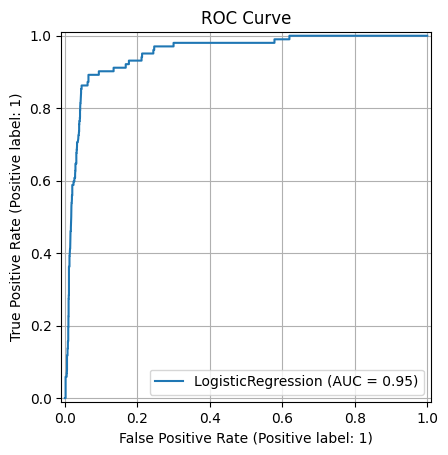


True Positives (TP - Correctly identified High Quality): 91
False Positives (FP - Standard wine called High Quality): 139
False Negatives (FN - High Quality wine missed): 11
True Negatives (TN - Correctly identified Standard Quality): 1922


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

# 9. Final Evaluation on the Unseen Test Set
y_pred = best_model.predict(X_test_final)
y_proba = best_model.predict_proba(X_test_final)[:, 1] # Probability for the positive class (1)

# 1. Accuracy
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {final_accuracy:.4f}\n")

# 2. Precision, Recall, F1
print("--- Classification Report (Precision, Recall, F1) ---")
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("--- Confusion Matrix ---")
print(conf_matrix)

# 4. ROC AUC Curve
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot the ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test_final, y_test)
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# Interpretation of Confusion Matrix (assuming standard format)
TN, FP, FN, TP = conf_matrix.ravel()
print(f"\nTrue Positives (TP - Correctly identified High Quality): {TP}")
print(f"False Positives (FP - Standard wine called High Quality): {FP}")
print(f"False Negatives (FN - High Quality wine missed): {FN}")
print(f"True Negatives (TN - Correctly identified Standard Quality): {TN}")